In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from PIL import Image
import rasterio
import os

folder_path = 'large_dataset/'

# find all images in the folder
images_names = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
images_ids = [int(image.split('large')[1].split('.')[0]) for image in images_names]
images_tif = [rasterio.open(folder_path + image) for image in images_names]

In [3]:
np_images = [np.moveaxis(image.read(), 0, -1) for image in images_tif]
nb_pixels = [image.shape[0] * image.shape[1] for image in np_images]

In [53]:
# keep ids of the images with more than 50000 pixels
keep_images_ids = [images_ids[i] for i in range(len(images_ids)) if nb_pixels[i] > 20000]
keep_np_images = [np_images[i] for i in range(len(np_images)) if nb_pixels[i] > 20000]

In [17]:

def gdal_get_pixel_of_longlat(fname, longlat, verbose=True):
    """
    returns the pixel coordinates for the points at longitude and latitude 
    (assuming a default altitude wrt the WGS84 reference ellipsoid) in the GeoTIFF image fname. 
    The CRS of the input GeoTIFF is determined from the metadata in the file.
    """
    # add vsicurl prefix if needed
    env = os.environ.copy()
    if fname.startswith(('http://', 'https://')):
        env['CPL_VSIL_CURL_ALLOWED_EXTENSIONS'] = fname[-3:]
        fname = '/vsicurl/{}'.format(fname)

    # form the query string for gdaltransform
    q = b''
    for coords in longlat:
        if len(coords) == 2:  # Only longitude and latitude provided
            coords = (*coords, 0)  # Append a default altitude of 0
        q = q + b'%f %f %f\n' % coords  # Unpack the tuple directly

    # call gdaltransform to convert longlat to pixel coordinates, -i does the inverse transformation
    cmdlist = ['gdaltransform', '-t_srs', "+proj=longlat", '-i', fname]
    if verbose:
        print('RUN: ' + ' '.join(cmdlist) + ' [long lat [alt] from stdin]')
    p = subprocess.Popen(cmdlist, env=env, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate(q)
    if p.returncode != 0:
        raise RuntimeError("Command failed: %s\nError message: %s" % (' '.join(cmdlist), err.decode()))

    # parse the output from gdaltransform to get pixel coordinates
    listeout = [list(map(float, x.split())) for x in out.decode().splitlines()]
    # remove last coordinate of each point (which is the altitude)
    listeout = [x[:2] for x in listeout]
    return listeout

def get_bbox(polygon):
    x = [p[0] for p in polygon]
    y = [p[1] for p in polygon]
    return [min(x), min(y), max(x), max(y)]

In [6]:
from transformers import SamModel, SamProcessor
import torch
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-03-13 17:39:40.254460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import json
import subprocess

with open('landfills_openstreetmap.geojson') as f:
    data = json.load(f)

In [7]:
def generate_mask(i):
    image = keep_np_images[i]
    idx = keep_images_ids[i]
    
    fname = f'large_dataset/large{idx}.tif'
    polygon = data['features'][idx]['geometry']['coordinates'][0]
    polygon = gdal_get_pixel_of_longlat(fname, polygon)
    box = get_bbox(polygon)
    
    # image_embeddings = model.get_input_embeddings(inputs["pixel_values"])
    inputs = processor(image, input_boxes=[[box]], return_tensors="pt")
    # inputs.pop("pixel_values", None)
    # inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    # choose mask with the highest confidence
    mask = masks[0].cpu().numpy()
    mask = np.moveaxis(mask.squeeze(), 0, -1).astype(np.float32)
    return mask

In [36]:
mask_sam = generate_mask(3)

RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]


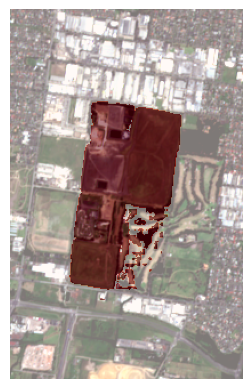

In [37]:
import matplotlib.pyplot as plt
# show the mask on the image
plt.imshow(keep_np_images[3])
plt.imshow(mask_sam.max(axis=2), alpha=0.5, cmap="Reds")
plt.axis("off")
plt.show()

RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]


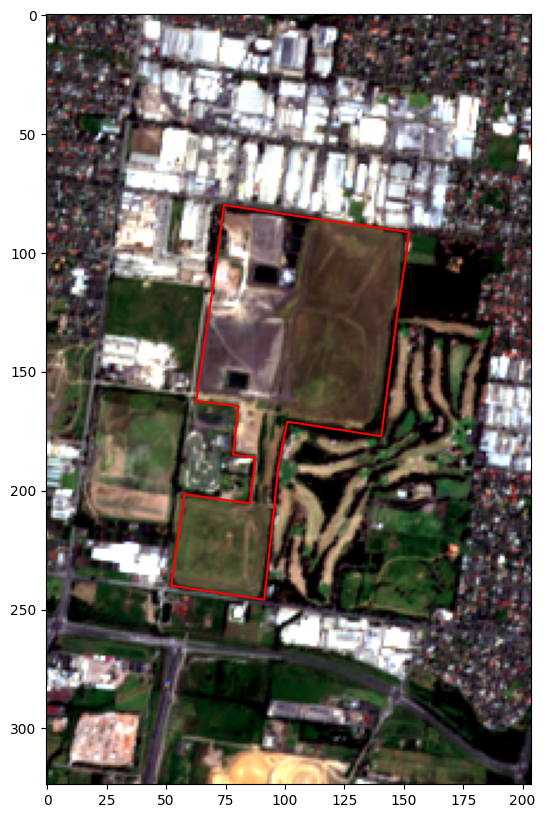

In [26]:
idx = keep_images_ids[3]
fname = f'large_dataset/large{idx}.tif'  
polygon = data['features'][idx]['geometry']['coordinates'][0]
# transform the polygon to pixel coordinates
polygon = gdal_get_pixel_of_longlat(fname, polygon)
RGB = rasterio.open(fname)
RGB = RGB.read()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(RGB.transpose(1, 2, 0))
ax.plot([x[0] for x in polygon], [x[1] for x in polygon], 'r-')

In [21]:
import cv2

def create_mask_from_polygon(image_shape, polygon):
    """
    Create a binary mask from a polygon.

    Parameters:
        image_shape (tuple): The shape of the image (height, width).
        polygon (list): A list of lists, where each inner list contains the [x, y] coordinates of a vertex.

    Returns:
        np.array: A binary mask with the same dimensions as the image.
    """
    # Convert polygon to the required format for cv2.fillPoly
    # It should be a numpy array of integers
    poly_array = np.array(polygon, dtype=np.int32)

    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # Fill the polygon with ones
    cv2.fillPoly(mask, [poly_array], color=(1))

    return mask

In [34]:
idx

2135

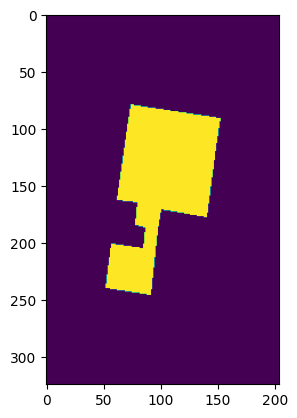

In [37]:
mask = create_mask_from_polygon(keep_np_images[3].shape[:2], polygon)
plt.imshow(mask)
# save the mask
plt.imsave(f'large_dataset/masks/mask{idx}.png', mask, cmap='gray')


In [40]:
image

NameError: name 'image' is not defined

In [57]:
keep_images_ids

[1825,
 1158,
 4752,
 3015,
 382,
 5316,
 2690,
 2848,
 2135,
 2121,
 2647,
 5128,
 17,
 5100,
 2109,
 194,
 779,
 4381,
 2041,
 2069,
 209,
 2243,
 2525,
 1038,
 2531,
 3149,
 3161,
 1762,
 585,
 2518,
 2530,
 4627,
 4633,
 2242,
 1993,
 1978,
 552,
 1950,
 2281,
 1207,
 744,
 2901,
 2083,
 4551,
 5129,
 156,
 142,
 2685,
 2849,
 1171,
 397,
 383,
 2444,
 4753,
 3941,
 3943,
 2491,
 424,
 4962,
 4751,
 2320,
 1629,
 2446,
 3758,
 2452,
 395,
 1173,
 2308,
 1601,
 4590,
 154,
 2877,
 14,
 815,
 4547,
 197,
 4209,
 3566,
 2678,
 28,
 5117,
 746,
 1946,
 544,
 2532,
 4157,
 2526,
 1761,
 2268,
 5274,
 1760,
 2527,
 2241,
 1984,
 2533,
 545,
 223,
 2731,
 2080,
 1589,
 828,
 2123,
 2876,
 141,
 2686,
 4750,
 5328,
 2490,
 2484,
 3942,
 421,
 3946,
 1823,
 2494,
 3952,
 5310,
 3013,
 2443,
 1638,
 5338,
 1374,
 192,
 838,
 1406,
 2641,
 1348,
 2133,
 743,
 5099,
 4393,
 2709,
 4436,
 2047,
 3832,
 3198,
 1957,
 1764,
 2251,
 4620,
 1980,
 1994,
 2523,
 1995,
 5259,
 1759,
 1981,
 3166,
 36

In [58]:
# pipeline to create the ground truth mask

def create_masks_dataset(path, keep_images_ids, data):
    for i in range(len(keep_images_ids)):
        try:
            idx = keep_images_ids[i]
            fname = f'large_dataset/large{idx}.tif'  
            polygon = data['features'][idx]['geometry']['coordinates'][0]
            # transform the polygon to pixel coordinates
            polygon = gdal_get_pixel_of_longlat(fname, polygon)
            mask = create_mask_from_polygon(keep_np_images[i].shape[:2], polygon)
            # crop mask and image to a square centering as much as possible the polygon
            # check if x or y axis is the longest
            if mask.shape[0] > mask.shape[1]:
                # crop the image
                image = keep_np_images[i][int(mask.shape[0]/2 - mask.shape[1]/2):int(mask.shape[0]/2 + mask.shape[1]/2)]
                # crop the mask
                mask = mask[int(mask.shape[0]/2 - mask.shape[1]/2):int(mask.shape[0]/2 + mask.shape[1]/2)]
            else:
                # crop the image
                image = keep_np_images[i][:, int(mask.shape[1]/2 - mask.shape[0]/2):int(mask.shape[1]/2 + mask.shape[0]/2)]
                # crop the mask
                mask = mask[:, int(mask.shape[1]/2 - mask.shape[0]/2):int(mask.shape[1]/2 + mask.shape[0]/2)]
            # transform image from uint16 to uint8
            image = image.astype(np.uint8)
            # save the mask
            plt.imsave(path + f'images/image_{idx}.png', image)
            plt.imsave(path + f'masks/mask_{idx}.png', mask, cmap='gray')
        except:
            print(f'Error with image {keep_images_ids[i]}')
        if i % 100 == 0:
            print(f'{i} images processed')
        
create_masks_dataset('new_dataset/', keep_images_ids, data)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1825.tif [long lat [alt] from stdin]
0 images processed
Error with image 1158
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large4752.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large3015.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large382.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large5316.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2690.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2848.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2121.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2647.ti

In [65]:
# load randomly 10 images and masks and display them
import random
import os
import matplotlib.pyplot as plt

def load_images_masks(path, n):
    images = random.sample(os.listdir(path + 'images/'), n)
    masks = [image.replace('image', 'mask') for image in images]
    images = [plt.imread(path + 'images/' + image) for image in images]
    masks = [plt.imread(path + 'masks/' + mask) for mask in masks]
    return images, masks

images, masks = load_images_masks('new_dataset/', 10)

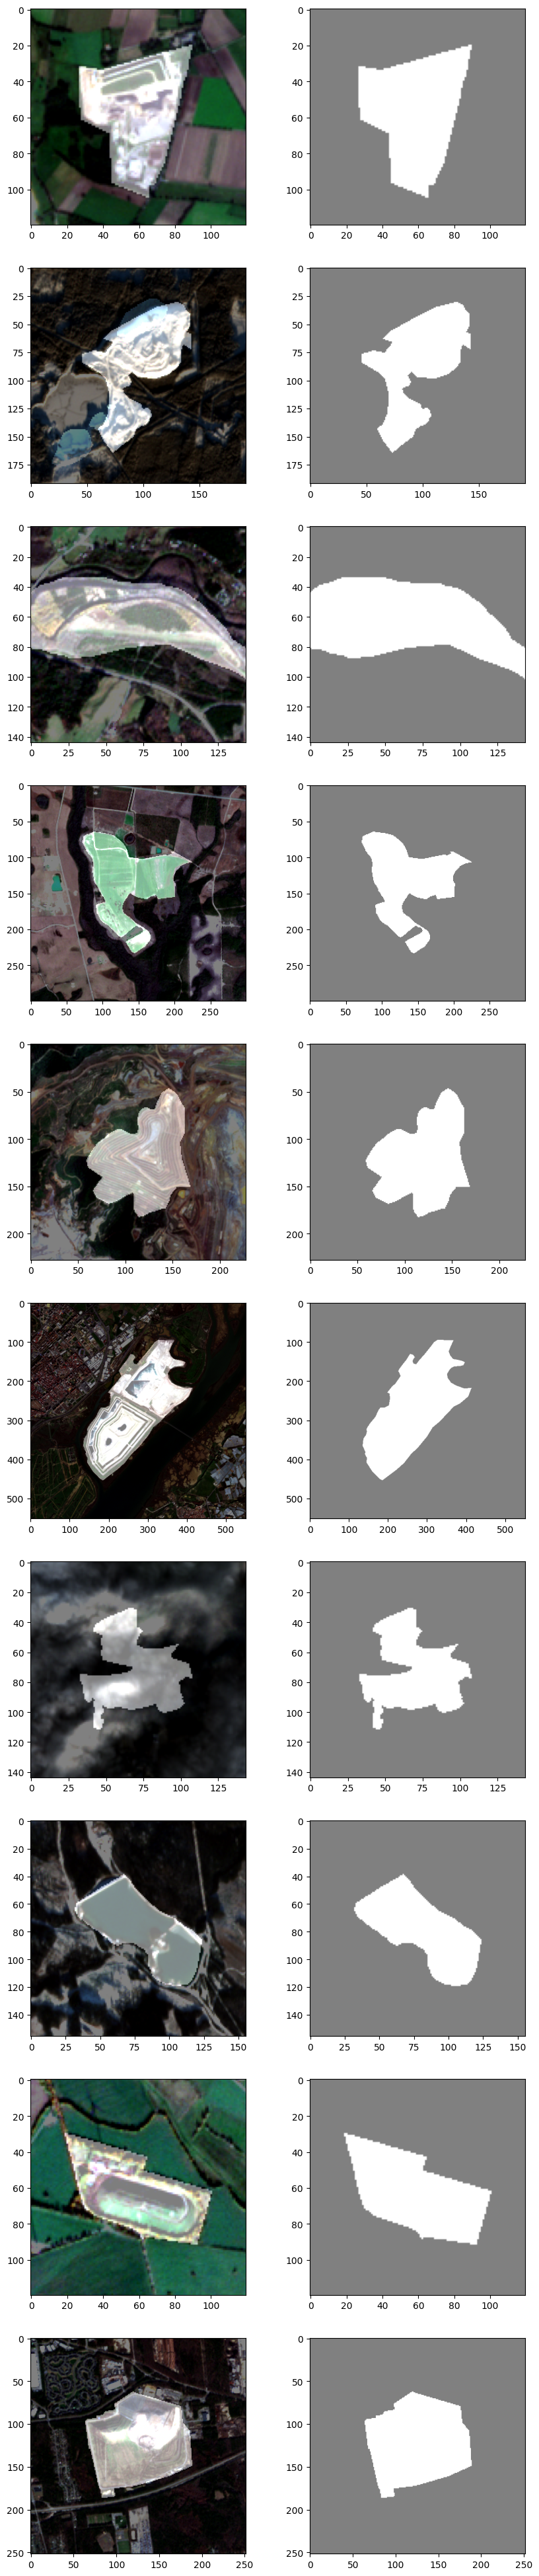

In [68]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 2, figsize=(10, 50))  # 10 rows for 10 pairs, 2 columns for images and masks

for i in range(10):  # assuming you have at least 10 pairs
    axs[i, 0].imshow(images[i])
    axs[i, 0].imshow(masks[i], cmap='gray', alpha=0.5)
    axs[i, 1].imshow(masks[i], cmap='gray', alpha=0.5)

plt.show()

(-0.5, 203.5, 323.5, -0.5)

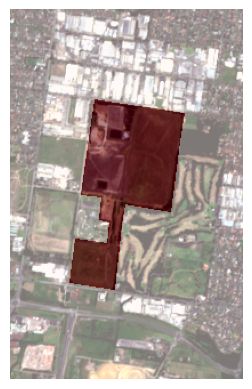

In [39]:
mask_gt = create_mask_from_polygon(RGB.shape[1:], polygon)
# show mask on the image
plt.imshow(RGB.transpose(1, 2, 0))
plt.imshow(mask_gt, alpha=0.5, cmap="Reds")
plt.axis("off")

In [40]:
def iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) of two binary masks.

    Parameters:
        mask1 (np.array): First binary mask.
        mask2 (np.array): Second binary mask.

    Returns:
        float: IoU score.
    """
    # Ensure that the masks are boolean arrays
    mask1 = mask1.astype(np.bool)
    mask2 = mask2.astype(np.bool)

    # Intersection and Union calculations
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


In [42]:
iou_score = iou(mask_sam.max(axis=2), mask_gt)
print(iou_score)

0.7844081705467844


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


In [45]:
# calculate the IoU for all the images
ious = []
sam_masks = []
gt_masks = []

for i in range(len(keep_images_ids[:20])):
    mask_sam = generate_mask(i)
    sam_masks.append(mask_sam.max(axis=2))
    idx = keep_images_ids[i]
    fname = f'large_dataset/large{idx}.tif'  
    polygon = data['features'][idx]['geometry']['coordinates'][0]
    # transform the polygon to pixel coordinates
    polygon = gdal_get_pixel_of_longlat(fname, polygon)
    mask_gt = create_mask_from_polygon(keep_np_images[i].shape[:2], polygon)
    gt_masks.append(mask_gt)
    ious.append(iou(mask_sam.max(axis=2), mask_gt))

RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large4752.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large4752.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large382.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large382.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2848.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2848.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large17.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large17.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large5100.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large5100.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2109.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2109.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large779.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large779.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2041.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2041.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large209.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large209.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2243.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2243.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1038.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1038.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large3161.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large3161.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1762.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1762.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2530.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2530.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2242.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2242.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1978.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large1978.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2281.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2281.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large5129.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large5129.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large156.tif [long lat [alt] from stdin]
RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large156.tif [long lat [alt] from stdin]


/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask1 = mask1.astype(np.bool)
/var/folders/s9/lcj2s8_n4ts0xz1cq_3ff80c0000gn/T/ipykernel_11454/4066250506.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask2.astype(np.bool)


In [46]:
ious

[0.8028033176879059,
 0.803015923231045,
 0.7489224137931034,
 0.7844081705467844,
 0.6714526190711951,
 0.9012266802964477,
 0.7780005418585749,
 0.8315715292459479,
 0.006173885637031351,
 0.8894348894348895,
 0.8604296815480725,
 0.8849025834692301,
 0.2810105263157895,
 0.8294091114118177,
 0.4683089974712456,
 0.8239864387625371,
 0.8709804851070554,
 0.8791989664082688,
 0.6489894701086957,
 0.5414208456243854]

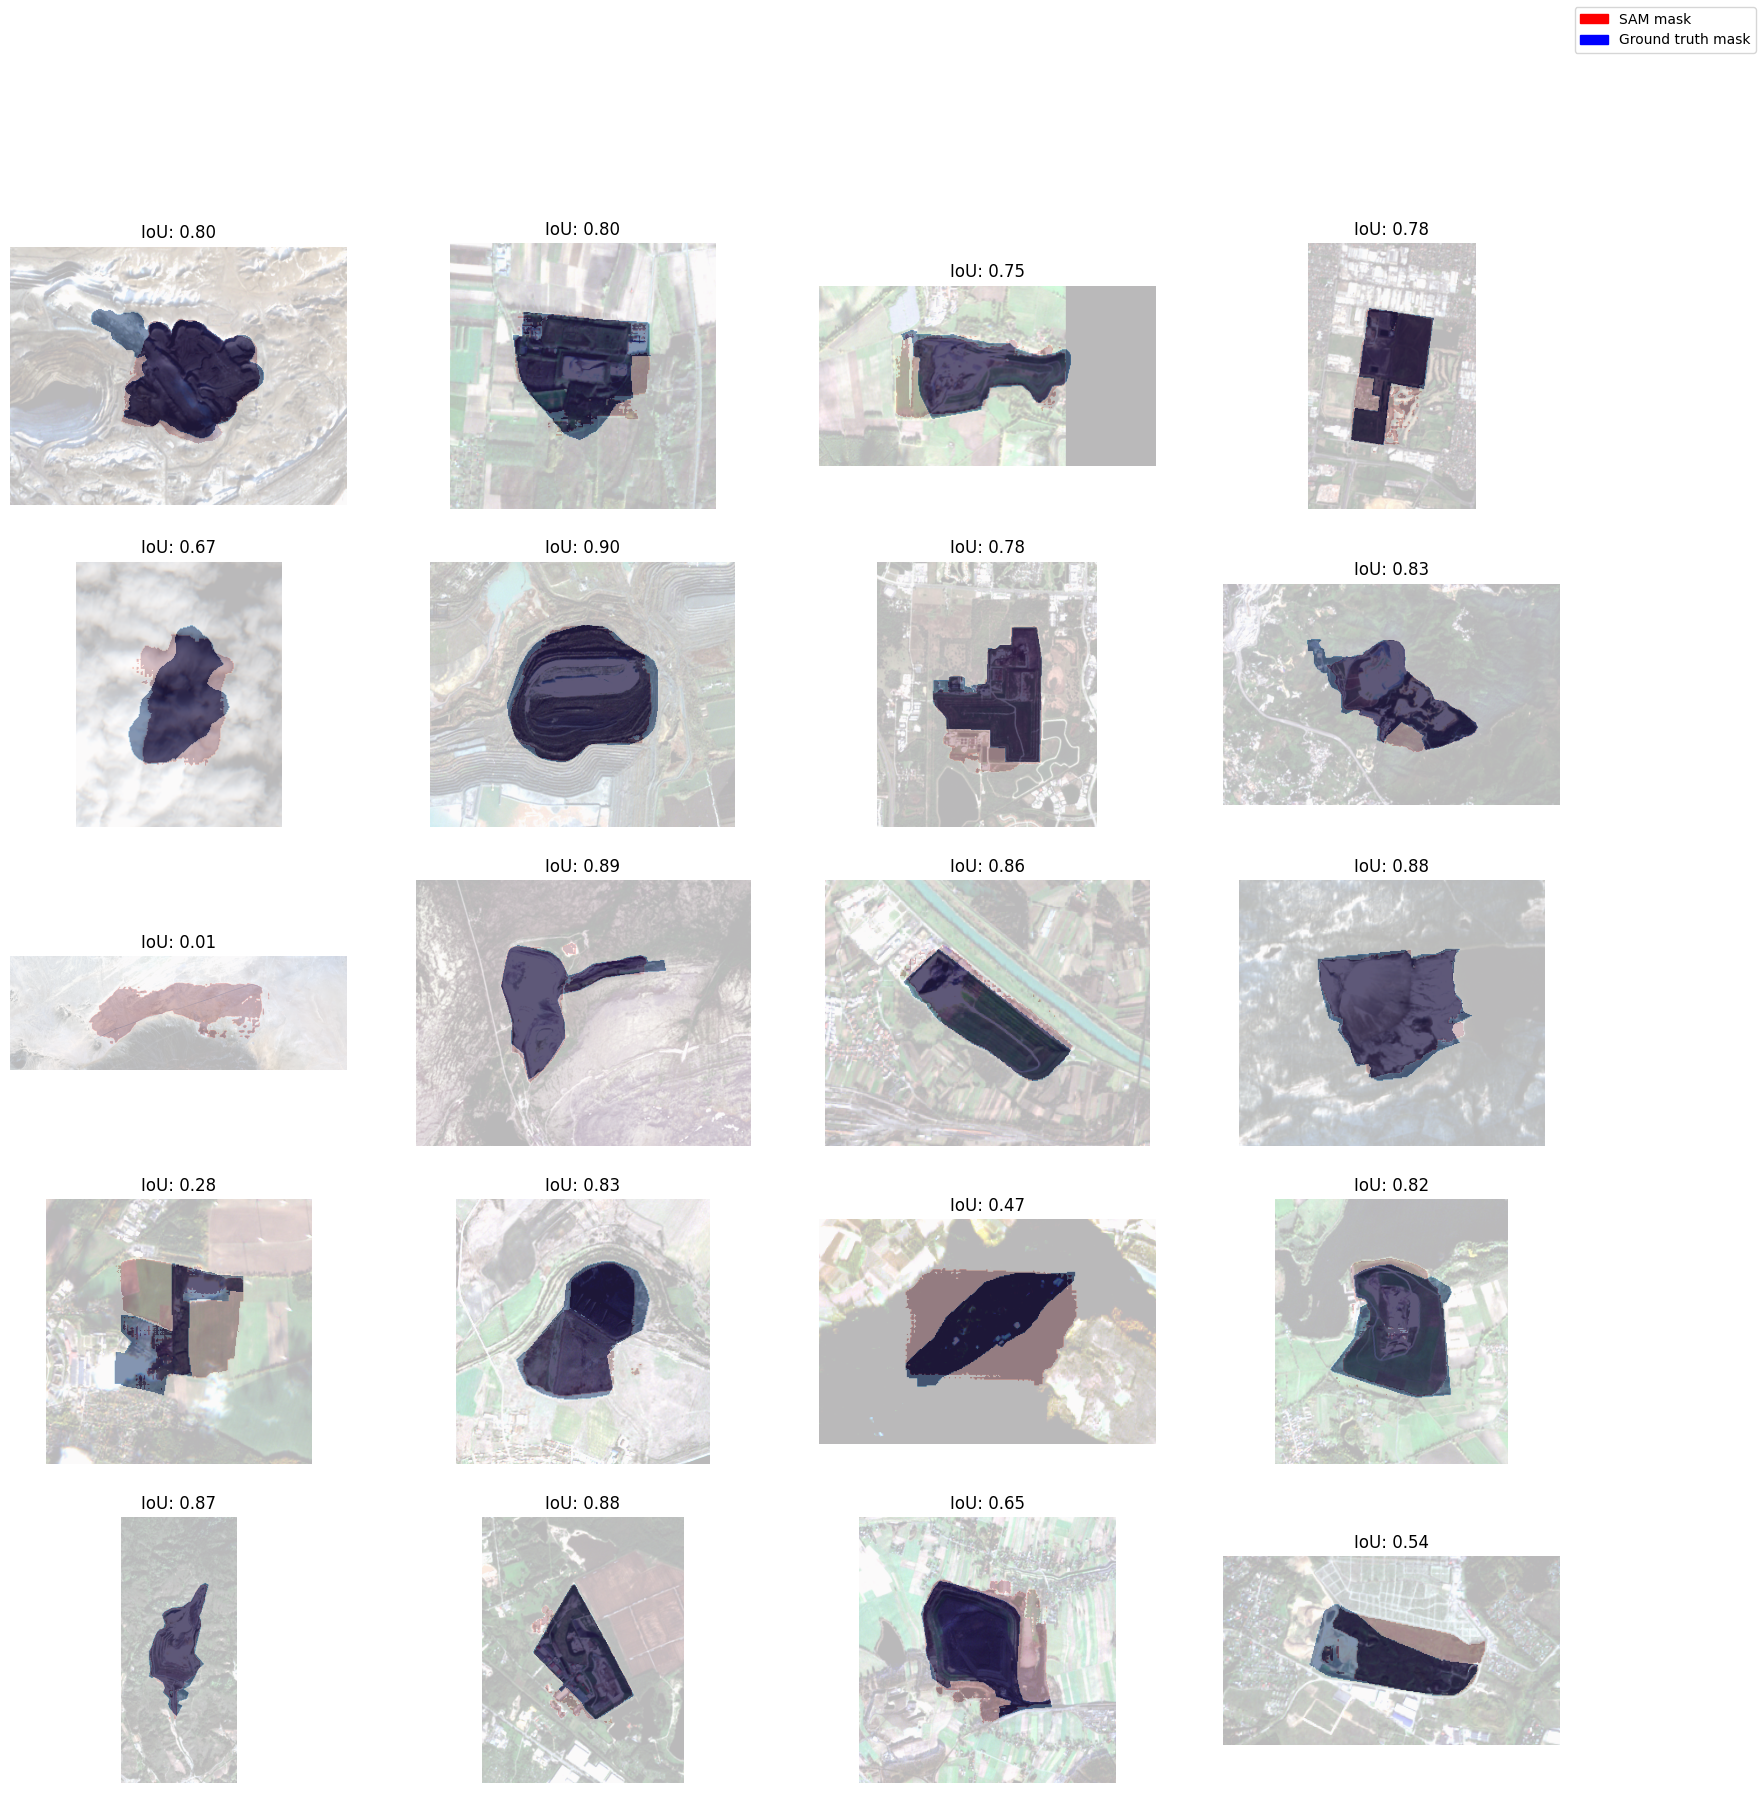

In [56]:
# show the 2 masks on the image
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(keep_np_images[i])
    ax.imshow(sam_masks[i], alpha=0.5, cmap="Reds")
    ax.imshow(gt_masks[i], alpha=0.5, cmap="Blues")
    ax.axis("off")
    ax.set_title(f"IoU: {ious[i]:.2f}")
# add a legend
import matplotlib.patches as mpatches
sam_patch = mpatches.Patch(color="red", label="SAM mask")
gt_patch = mpatches.Patch(color="blue", label="Ground truth mask")
fig.legend(handles=[sam_patch, gt_patch], loc="upper right")